<a href="https://colab.research.google.com/github/Pterjudin/Diagnosis_of_psychiatric_diseases_from_brain_MRI_data/blob/main/Tajudeen_Oyindamola_Tajudeen_3929498.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h3><font color='red'>Early diagnosis/prognosis of psychiatric diseases from brain MRI data</h3></center>

<i>
In this project, we try to diagnose psychiatric diseases from brain MRI data early. Magnetic Resonance Imaging (MRI) is an imaging technique majorly used in radiology to form pictures of the anatomy and physiological processes of the body. Strong magnetic fields, radio waves, and magnetic field gradients are used in MRI scanners to generate images of different body organs; in our case, the brain[1].
</i>
<p>
<i>
To diagnose psychiatric diseases, I would train a Convolutional Neural Network (CNN) using TensorFlow to classify the images from the data given. This is a supervised classification problem.
</i>
</p> 
<p>
<h6><font color='red'>[1] En.wikipedia.org. 2021. Magnetic resonance imaging. [online] Available at <https://en.wikipedia.org/wiki/Magnetic_resonance_imaging> [Accessed 20 January 2021].</h6></p>

In [1]:
# This code block mounts my google drive where I have the given dataset.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
####################################IMPORTING THE NEEDED LIBRARIES#######################################################
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
############################################TENSORFLOW IMPORTS#########################################################
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Link to the Zip File provided
zipped_data = '/content/drive/MyDrive/Brain_UniMI.zip'
cwd = os.getcwd()
base_dir_for_data = os.path.join(cwd, "/Data")
# Unzipping the file
with zipfile.ZipFile(zipped_data,"r") as zip_ref:
    zip_ref.extractall(base_dir_for_data)
# Checking if my file are correctly loaded
arr = os.listdir(base_dir_for_data)
arr

['Classification.xlsx',
 'Brain_MRI_DataLoader.ipynb',
 'Data_batch_1',
 '.ipynb_checkpoints',
 'Classification_data_batch_1.xlsx']

In [4]:
# BASE_DIR="./Data_Batch_1/"
BASE_DIR=os.path.join(base_dir_for_data, "./Data_Batch_1/" )
TRAIN_IMAGES_DIR=os.path.join(base_dir_for_data,'train_images')

## Loading the labels
data_df=pd.read_excel('/Data/Classification.xlsx')
data_df["Class"] = data_df["Diagnosis"] > 0
data_df.Class = data_df.Class.astype('int')

# Declaring the Labels
labels = data_df['Diagnosis']

# Taking a quick look at the dataset.
data_df.head() 

,ID_CF,First Episodes (FEP) / Healthy Control (HC),Diagnosis,Class
0,CF_001,FEP,3,1
1,CF_002,FEP,3,1
2,CF_003,FEP,1,1
3,CF_004,FEP,1,1
4,CF_005,FEP,2,1


In [5]:
data_df.describe()

,Diagnosis,Class
count,792.000000,792.000000
mean,1.087121,0.366162
std,1.912428,0.482059
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,7.000000,1.000000


In [6]:
# Getting the ni.gz format
import glob 
glob_files = (glob.glob("/Data/Data_batch_1/*.*")) 

In [7]:
# Check if file was loaded successfully
glob_files

['/Data/Data_batch_1/wCF_013_MRI_sMRI_CF_013.nii.gz',
 '/Data/Data_batch_1/wCF_100_MRI_sMRI_CF_100.nii.gz',
 '/Data/Data_batch_1/wCF_053_MRI_sMRI_CF_053.nii.gz',
 '/Data/Data_batch_1/wCF_079_MRI_sMRI_CF_079.nii.gz',
 '/Data/Data_batch_1/wCF_092_MRI_sMRI_CF_092.nii.gz',
 '/Data/Data_batch_1/wCF_014_MRI_sMRI_CF_014.nii.gz',
 '/Data/Data_batch_1/wCF_085_MRI_sMRI_CF_085.nii.gz',
 '/Data/Data_batch_1/wCF_098_MRI_sMRI_CF_098.nii.gz',
 '/Data/Data_batch_1/wCF_051_MRI_sMRI_CF_051.nii.gz',
 '/Data/Data_batch_1/wCF_042_MRI_sMRI_CF_042.nii.gz',
 '/Data/Data_batch_1/wCF_024_MRI_sMRI_CF_024.nii.gz',
 '/Data/Data_batch_1/wCF_017_MRI_sMRI_CF_017.nii.gz',
 '/Data/Data_batch_1/wCF_019_MRI_sMRI_CF_019.nii.gz',
 '/Data/Data_batch_1/wCF_074_MRI_sMRI_CF_074.nii.gz',
 '/Data/Data_batch_1/wCF_033_MRI_sMRI_CF_033.nii.gz',
 '/Data/Data_batch_1/wCF_039_MRI_sMRI_CF_039.nii.gz',
 '/Data/Data_batch_1/wCF_082_MRI_sMRI_CF_082.nii.gz',
 '/Data/Data_batch_1/wCF_031_MRI_sMRI_CF_031.nii.gz',
 '/Data/Data_batch_1/wCF_027

In [8]:
# Creating an array to store the labels
Labels=[] 
# Creating an array to store the images
Features=[] 

# Looping over glob_files for .gz file and  thier labels.
for globfile, label in zip(glob_files, labels):
    # Reading the .gz file 
    zipimgs = nb.load(globfile) 
    # Number of image
    n_img = (zipimgs.get_fdata().shape[0]) 
    # Looping over all images
    for i in range((n_img)): 
        Features.append(zipimgs.get_fdata()[i])
        if(label > 1):
            Labels.append(1)
        else:
            Labels.append(0)


In [9]:
# Splitting the Dataset into Train and Test Datasets using a test dataset that is 33% of the original data.

X_train, X_test, Y_train, Y_test = train_test_split(np.array(Features), np.array(Labels), test_size=0.33)

In [10]:
# A Quick Look at the Shape of our Test Data
X_train.shape

(5081, 95, 79)

In [11]:
# A Quick Look at the Shape of our Test Data
X_test.shape

(2503, 95, 79)

Shape of Feature and Label of Dataset below.
Train: Feature is (5081, 95, 79) and Label is (5081,)
Test: Feature is (2503, 95, 79) and Label is (2503,)


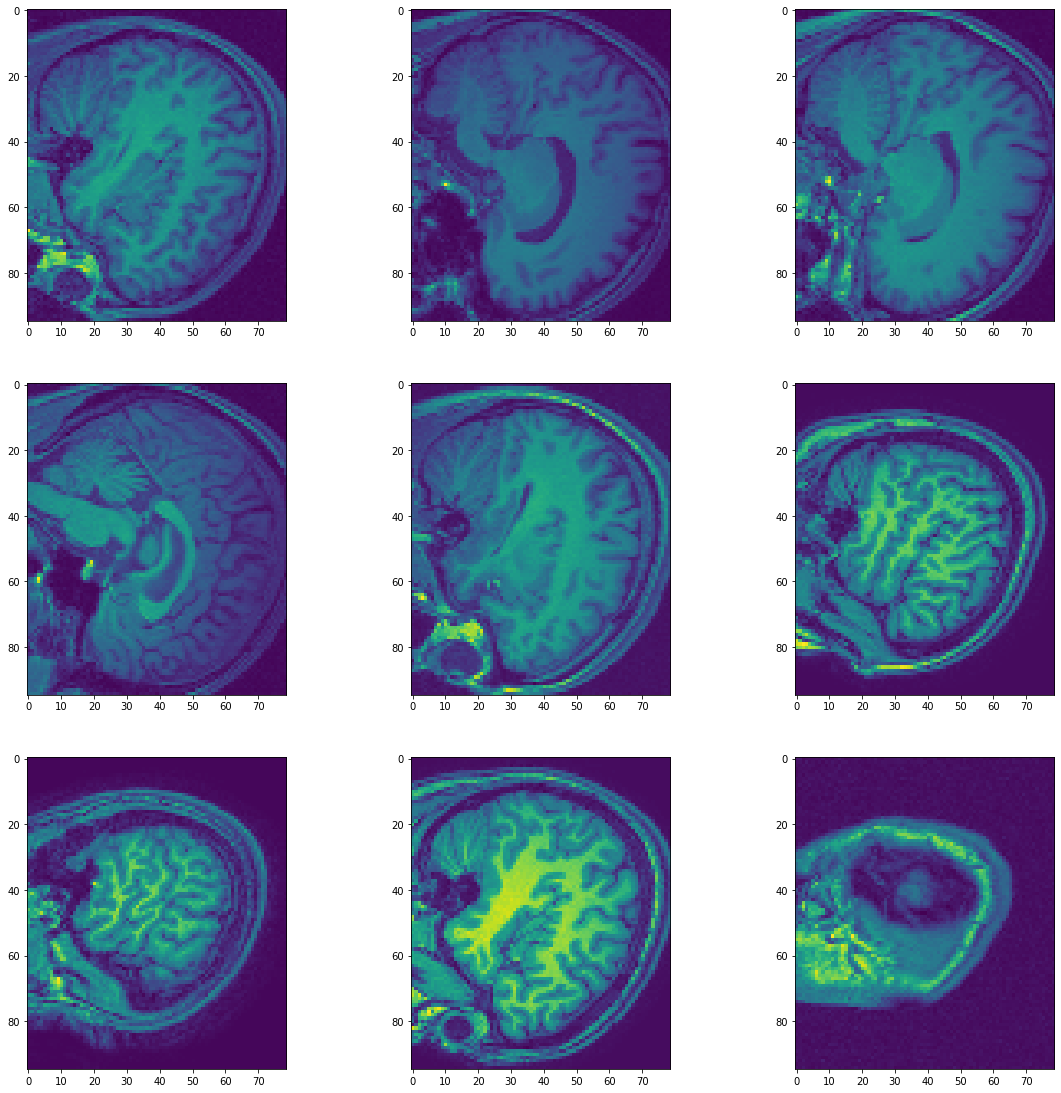

In [12]:
print("Shape of Feature and Label of Dataset below.")
print(f'Train: Feature is {X_train.shape} and Label is {Y_train.shape}')
print(f'Test: Feature is {X_test.shape} and Label is {Y_test.shape}')


# Plotting some of the images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i])

# Increasing the display size of the plot.
fig = plt.gcf()
fig.set_size_inches(19.5, 19.5)    
# show the figure
plt.show()

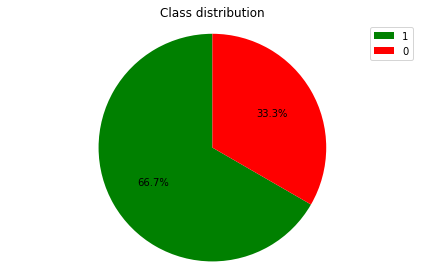

In [13]:
temp=pd.DataFrame()  ## Temporary data frame
temp['labels']=Labels ## Stroing labels for visualization
labels = list(temp['labels'].unique())
sizes = list(temp['labels'].value_counts())
colors = ['green', 'red']
patches, texts,per = plt.pie(sizes, colors=colors, startangle=90,autopct='%0.1f%%')
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.title('Class distribution')
plt.tight_layout()
fig.set_size_inches(19.5, 19.5)
plt.show()

In [14]:

# Function to scale dataset
def scale(train, test):
    """
          This function scales the dataset and also changes the type to float32 
    """ 
    scaled_train = train.astype('float32')
    scaled_test = test.astype('float32')
    # RGB values is between 0 and 255
    # We are scaling them so that every value is between 0 and 1
    scaled_train /= 255.0
    scaled_test /= 255.0
    # 
    return scaled_train, scaled_test

In [15]:
X_train

array([[[ 36.,  21.,  14., ...,  49.,  22.,  22.],
        [ 21.,  35.,  24., ...,  38.,  13.,  21.],
        [ 77.,  31.,  19., ...,  25.,   9.,  26.],
        ...,
        [ 78., 105.,  46., ...,  21.,  14.,  17.],
        [ 15.,  36.,  42., ...,  17.,  26.,  29.],
        [ 33.,  58.,  48., ...,  38.,   7.,  32.]],

       [[ 15.,  26.,  18., ...,  14.,  20.,  16.],
        [ 36.,  29.,  48., ...,  16.,  25.,  16.],
        [ 12.,  65.,  26., ...,  17.,  40.,  23.],
        ...,
        [627., 551., 434., ...,  31.,   6.,  24.],
        [256., 262., 285., ...,  30.,  30.,  12.],
        [214., 154.,  66., ...,  17.,  23.,  24.]],

       [[ 34.,  33.,  54., ...,  15.,  28.,  24.],
        [ 36.,  26.,  28., ...,  19.,  23.,  33.],
        [ 80.,  55.,  24., ...,  28.,  19.,  18.],
        ...,
        [ 68.,   8., 143., ...,  25.,  17.,  17.],
        [ 77.,  77.,  70., ...,  17.,  25.,  20.],
        [ 95.,  97.,  79., ...,  17.,  26.,  37.]],

       ...,

       [[ 66.,  91.,  87

In [16]:
X_test

array([[[  4.,   4.,   7., ...,   0.,   0.,   0.],
        [ 15.,   8.,  24., ...,   0.,   0.,   0.],
        [125., 131., 117., ...,   0.,   0.,   0.],
        ...,
        [188., 109.,  76., ...,   0.,   0.,   0.],
        [198., 182.,  95., ...,   0.,   0.,   0.],
        [214., 210., 115., ...,   0.,   0.,   0.]],

       [[ 36.,  51., 104., ...,  25.,  24.,  17.],
        [ 39.,  58.,  94., ...,  21.,  24.,  26.],
        [180., 208., 295., ...,   9.,  16.,  21.],
        ...,
        [291., 532., 689., ...,  24.,  28.,  22.],
        [384., 257., 332., ...,  12.,  20.,  20.],
        [296., 278., 267., ...,  26.,  20.,  30.]],

       [[ 48.,  47.,  79., ...,   0.,   0.,   0.],
        [189., 189., 177., ...,   0.,   0.,   0.],
        [210., 187., 195., ...,   0.,   0.,   0.],
        ...,
        [181., 158., 104., ...,   0.,   0.,   0.],
        [113.,  50.,  18., ...,   0.,   0.,   0.],
        [ 15.,   9.,   8., ...,   0.,   0.,   0.]],

       ...,

       [[ 31.,  19.,  18

In [17]:
# Reshaping my train and test dataset
# For training with Keras We have to add the color column.
X_train = X_train.reshape((X_train.shape[0], 95, 79, 1))
X_test = X_test.reshape((X_test.shape[0], 95, 79, 1))

# Creating a scaled training amd test input features 
X_train, X_test = scale(X_train, X_test)

**Model without Segmentation:**
We train the neural network with a set of images with labels (yes or no) and it has the ability to understand the difference between the two classes. Therefore, when we give the neural network a new unlabeled image, it can classify that image with the knowledge acquired during the training process.

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(95, 79, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# Check Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 93, 77, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 38, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 8, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0

In [19]:
# prepare pixel data
X_train, X_test = scale(X_train, X_test)

# fit model
without_aug_history = model.fit(X_train,Y_train, epochs=100, batch_size=150, validation_data=(X_test, Y_test), verbose=1,shuffle=True)
# evaluate model
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy on test set :", '> %.3f' % (acc * 100.0))

Epoch 1/100
34/34 [==============================] - 5s 74ms/step - loss: 0.6586 - acc: 0.6372 - val_loss: 0.6390 - val_acc: 0.6632
Epoch 2/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6408 - acc: 0.6611 - val_loss: 0.6392 - val_acc: 0.6632
Epoch 3/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6337 - acc: 0.6714 - val_loss: 0.6417 - val_acc: 0.6632
Epoch 4/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6432 - acc: 0.6614 - val_loss: 0.6389 - val_acc: 0.6632
Epoch 5/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6349 - acc: 0.6701 - val_loss: 0.6422 - val_acc: 0.6632
Epoch 6/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6377 - acc: 0.6660 - val_loss: 0.6395 - val_acc: 0.6632
Epoch 7/100
34/34 [==============================] - 2s 45ms/step - loss: 0.6292 - acc: 0.6782 - val_loss: 0.6389 - val_acc: 0.6632
Epoch 8/100
34/34 [==============================] - 2s 45ms/step - loss: 0.

<center> <h3>Visualizing My Results</h3> </center>

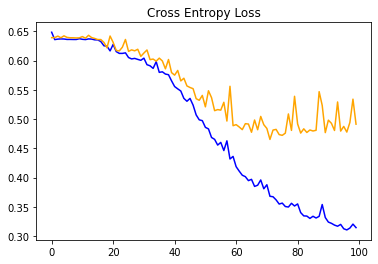

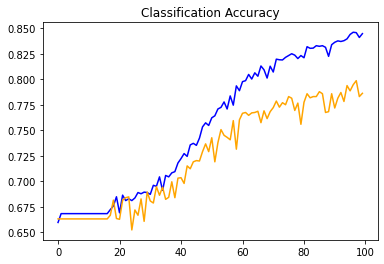

In [20]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(without_aug_history.history['loss'], color='blue', label='train')
plt.plot(without_aug_history.history['val_loss'], color='orange', label='test')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(without_aug_history.history['acc'], color='blue', label='train')
plt.plot(without_aug_history.history['val_acc'], color='orange', label='test')
plt.show()

<center><h3>
Model with Segmentation:
</h3></center>
Data imbalance is where the number of observations per class is not equally distributed. In order to solve this, we use a technique called Data Augmentation. This is a very important aspect in medicine where there will be many instances of data imbalance. 
In Data Augmentation, we take a particular MRI image and perform various sorts of image enhancements such as rotate, mirror and flip to get more number of images. We will apply more augmentation to the class with less number of images to get approximately equal number of images to both classes.

In [21]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# prepare iterator
it_train = datagen.flow(X_train, Y_train, batch_size=64)
# fit model
steps = int(X_train.shape[0] / 64)
aug_history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=100, validation_data=(X_test, Y_test), verbose=1)
# evaluate model
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy on test set :", '> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
79/79 [==============================] - 7s 76ms/step - loss: 0.6373 - acc: 0.6693 - val_loss: 0.5716 - val_acc: 0.7671
Epoch 2/100
79/79 [==============================] - 6s 75ms/step - loss: 0.6363 - acc: 0.6685 - val_loss: 0.5688 - val_acc: 0.7687
Epoch 3/100
79/79 [==============================] - 6s 75ms/step - loss: 0.6357 - acc: 0.6697 - val_loss: 0.5670 - val_acc: 0.7687
Epoch 4/100
79/79 [==============================] - 6s 75ms/step - loss: 0.6373 - acc: 0.6675 - val_loss: 0.5649 - val_acc: 0.7687
Epoch 5/100
79/79 [==============================] - 6s 75ms/step - loss: 0.6360 - acc: 0.6673 - val_loss: 0.5621 - val_acc: 0.7715
Epoch 6/100
79/79 [==============================] - 6s 74ms/step - loss: 0.6367 - acc: 0.6681 - val_loss: 0.5616 - val_acc: 0.7691
Epoch 7/100
79/79 [==============================] - 6s 74ms/step - loss: 0.6355 - acc: 0.6691 - val_loss: 0.5636 - val_acc: 0.7667
Epoch 8/100
79/79 [==============================] - 6s 75ms/step - loss: 0.

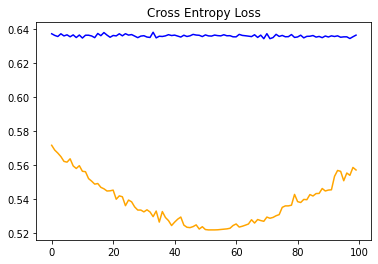

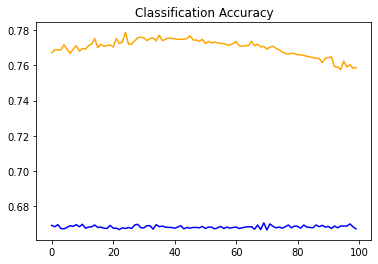

In [22]:
# plot loss
plt.title('Cross Entropy Loss')
plt.plot(aug_history.history['loss'], color='blue', label='train')
plt.plot(aug_history.history['val_loss'], color='orange', label='test')
plt.show()
# plot accuracy
plt.title('Classification Accuracy')
plt.plot(aug_history.history['acc'], color='blue', label='train')
plt.plot(aug_history.history['val_acc'], color='orange', label='test')
plt.show()

**Comparison of the two models**

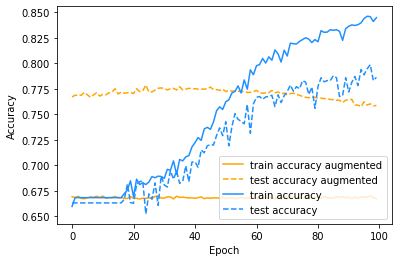

In [23]:
## Comparison:
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(aug_history.history['acc'],
         label='train accuracy augmented',
         c='orange', ls='-')
plt.plot(aug_history.history['val_acc'],
         label='test accuracy augmented',
         c='orange',ls='--')

plt.plot(without_aug_history.history['acc'],
         label='train accuracy',
         c='dodgerblue', ls='-')
plt.plot(without_aug_history.history['val_acc'],
         label='test accuracy',
         c='dodgerblue', ls='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

From the above image, we see that the accuracy of the training dateset keeps improving with each iteration. This means that the Neural Network model is able to improve in classifying the image as Tumor or Not a Tumor. At the end of the 100th epoch, we see that the trained CNN model has a validation accuracy of 79% and 76%.